In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler

In [2]:
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


In [ ]:
econ_sentiment_data = 'data/economic_sentiment_dataset.csv'
fin_stab_data = 'data/financial_stability_dataset.csv'
full_mac_data = 'data/full_macro_data.csv'
merged_dataset = 'data/merged_dataset.csv'

#The datasets before merged_dataset were not used individually, but they're there to show the raw datasets which made up the eventual merged_dataset
df4 = pd.read_csv(merged_dataset)

In [ ]:
df4['DATE'] = pd.to_datetime(df4['DATE'])

#Extract year, month, and day as separate features. Idea behind this is to help the model notice seasonal patterns
df4['Year'] = df4['DATE'].dt.year
df4['Month'] = df4['DATE'].dt.month
df4['Day'] = df4['DATE'].dt.day

#Drop date column
df4.drop(columns=['DATE'], inplace=True)
df4.drop(df4.index[0:649]) #Start with 2000 to avoid overrepresentation of a time when interest rate data was scarce
df4.drop(columns=['Date','date', 'Change %'], inplace=True) 
df4['change_percent'] = (df4['ir'] - df4['ir'].shift(1))/df4['ir'].shift(1) #Current - Previous; does not assume future knowledge
df4['change_percent'] = df4['change_percent'].fillna(0) #Change% dropped and replaced with changed_percent as values were innaccurate at times

scaler = RobustScaler()
ir_scaler = RobustScaler()

cols_to_scale = df4.columns.difference(['ir']).drop(df4.columns[-1])

robust_df = df4.copy()
robust_df[cols_to_scale] = scaler.fit_transform(df4[cols_to_scale])
robust_df['ir'] = ir_scaler.fit_transform(df4[['ir']])
robust_df.head



<bound method NDFrame.head of       REAINTRATREARAT10Y       GDP    unrate       psr        m2     dspic  \
0               4.466311 -2.302642  0.642857  1.782609 -1.047034 -2.372362   
1               4.466311 -2.302642  0.642857  1.782609 -1.047034 -2.372362   
2               4.466311 -2.302642  0.642857  1.782609 -1.047034 -2.372362   
3               4.466311 -2.302208  0.642857  1.782609 -1.047034 -2.372362   
4               4.466311 -2.302208  0.642857  1.782609 -1.047034 -2.372362   
...                  ...       ...       ...       ...       ...       ...   
6357            0.258367  1.750231 -0.392857  0.217391  1.860899  1.182709   
6358            0.692103  1.750231 -0.392857  0.217391  1.860899  1.182709   
6359            0.271672  1.750231 -0.392857  0.217391  1.860899  1.182709   
6360            0.271672  1.750231 -0.392857  0.217391  1.860899  1.182709   
6361            0.271672  1.750231 -0.392857  0.217391  1.860899  1.182709   

           pce      reer       ir

In [ ]:
#Setting up features and labels
target = 'ir'
feats = robust_df.drop(columns=[target]).values
labels = robust_df[target].values.reshape(-1, 1)

X_tensor = torch.tensor(feats, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.float32)

def create_sequences(X, y, window_size):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - window_size):
        sequences_X.append(X[i : i + window_size])  #Take window_size past steps (30)
        sequences_y.append(y[i + window_size])  #Target is the next step after the window
    return torch.stack(sequences_X), torch.stack(sequences_y)

window_size = 30
X_tensor, y_tensor = create_sequences(X_tensor, y_tensor, window_size)

X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5) #Did train_test_split twice to preserve proper proportions of train:val:test

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
class InterestRateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=272, num_layers=4):
        super(InterestRateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.batch_norm(x[:, -1, :])
        x = self.fc(x)
        return x
        
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
class DoubleRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(torch.sqrt(self.mse(yhat,y)))

input_size = X_tensor.shape[2]  
model = InterestRateLSTM(input_size)
#model.load_state_dict(torch.load("model_weights_gen5plus.pth", weights_only=True)) #Uncomment to load weights
criterion = DoubleRMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [ ]:
def compute_metrics(loader, model, criterion):
    total_loss, total_mae, total_rmse = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            mae = torch.mean(torch.abs(outputs - batch_y)).item()
            rmse = torch.sqrt(torch.mean((outputs - batch_y) ** 2)).item()

            total_loss += loss.item()
            total_mae += mae
            total_rmse += rmse

    avg_loss = total_loss / len(loader)
    avg_mae = total_mae / len(loader)
    avg_rmse = total_rmse / len(loader)
    return avg_loss, avg_mae, avg_rmse

#Train Loop START
epochs = 200
patience = 20 
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    total_train_loss, total_train_mae, total_train_rmse = 0, 0, 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_mae += torch.mean(torch.abs(outputs - batch_y)).item()
        total_train_rmse += torch.sqrt(torch.mean((outputs - batch_y) ** 2)).item()

    #Compute training loss
    train_loss = total_train_loss / len(train_loader)
    train_mae = total_train_mae / len(train_loader)
    train_rmse = total_train_rmse / len(train_loader)

    #Compute validation loss
    val_loss, val_mae, val_rmse = compute_metrics(val_loader, model, criterion)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.6f}, MAE: {train_mae:.6f}, RMSE: {train_rmse:.6f} | "
          f"Val Loss: {val_loss:.6f}, MAE: {val_mae:.6f}, RMSE: {val_rmse:.6f}")

    #Early stop mechanism
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0 
        best_model_state = model.state_dict()  #Save best model (lowest validation loss)
    else:
        early_stop_counter += 1 

    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}. Stopping training.")
        break

#Use best model on test
model.load_state_dict(best_model_state)
test_loss, test_mae, test_rmse = compute_metrics(test_loader, model, criterion)
print(f"\nFinal Test Results - Loss: {test_loss:.6f}, MAE: {test_mae:.6f}, RMSE: {test_rmse:.6f}")
torch.save(model.state_dict(), "model_weights.pth")

In [38]:
torch.save(model, 'best_model_so_far.pth')

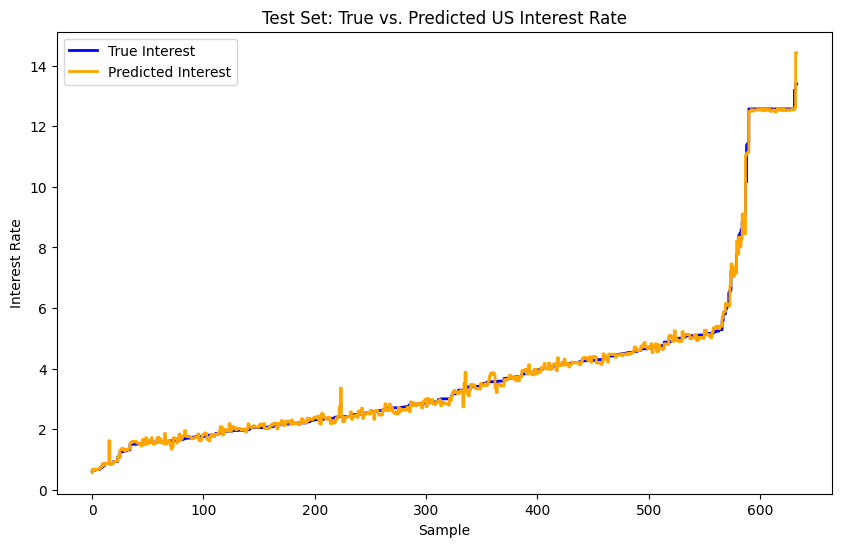

In [ ]:
import matplotlib.pyplot as plt

# Get predictions and actual values from test set
model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        actuals.extend(batch_y.numpy().flatten())
        predictions.extend(outputs.numpy().flatten())

actuals = np.array(actuals)
predictions = np.array(predictions)

sorted_indices = np.argsort(actuals)
actuals = ir_scaler.inverse_transform(actuals[sorted_indices].reshape(-1,1))
predictions = ir_scaler.inverse_transform(predictions[sorted_indices].reshape(-1,1))

plt.figure(figsize=(10, 6))
plt.step(range(len(actuals)), actuals, label="True Interest", color="blue", linewidth=2)
plt.step(range(len(predictions)), predictions, label="Predicted Interest", color="orange", linewidth=2)

plt.xlabel("Sample")
plt.ylabel("Interest Rate")
plt.title("Test Set: True vs. Predicted US Interest Rate")
plt.legend()
plt.show()